In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as m

In [ ]:
class Value():
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    return (f"Value(data = {self.data})")

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other);
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other);
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), " we only support int / float in power"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    other = other if isinstance(other, Value) else Value(other);
    return self + (-other)


  def tanh(self):
    x = self.data;
    t = (m.exp(2*x) - 1) / (m.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data;
    out = Value(m.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b; d.label='d'
e = d + c ; e.label='e'
f = Value(-2.0, label= 'f')
l = e * f; l.label='l'

In [ ]:
d._prev, d._op

({Value(data = -3.0), Value(data = 2.0)}, '*')

### Code to vizualize the Neural Net

In [ ]:
from graphviz import Digraph

def trace (root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_root(root):
  dot = Digraph(format="svg", graph_attr= {"rankdir":"LR"}) # LR = Left to Right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))

    # for any value in the graph, create a rectangular ('record') node for it
    dot.node (name = uid, label = "{ %s | data %.4f | grad %.4f}" % ( n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node (name = uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge (uid + n._op, uid)
  for n1, n2 in edges:
    # connect ni to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# a.grad=6.0000
# b.grad=-4.0000
# c.grad=-2.0000
# d.grad=-2.0000
# e.grad=-2.0000
# f.grad=4.0000
# l.grad=1.0000

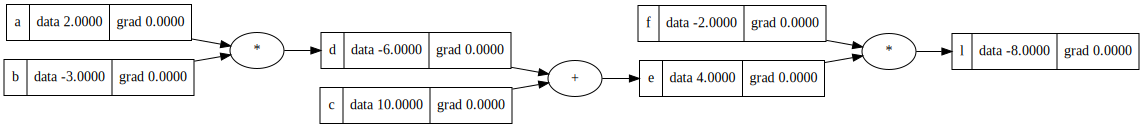

In [ ]:
draw_root(l)

In [ ]:
# d = a * b
# dd/da = b
# dd/db = a
# dl/ da = dl/de * de/dd * dd/da
# dl/ da = 1 * -2 *  -3 = 6

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a * b
e = d + c
l = e * f

l.data

-8.0

### Math behind Artifical Neuron  
![Math model of neuron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

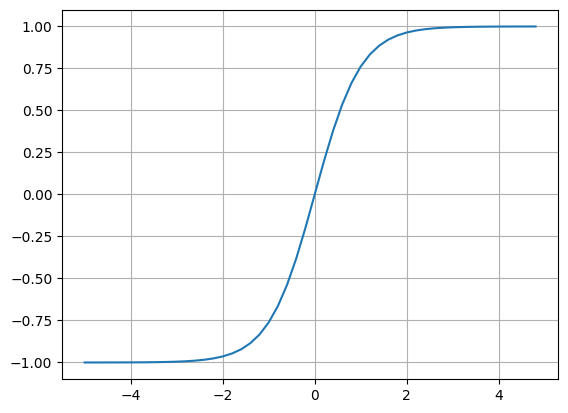

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

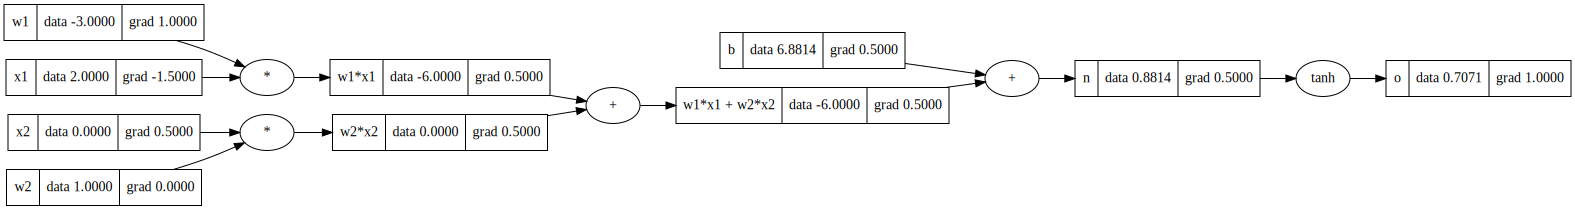

In [ ]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bais
b = Value(6.8813735870195432, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1*x1'
w2x2 = w2 * x2; w2x2.label = 'w2*x2'
w1x1w2x2 = w1x1 + w2x2 ; w1x1w2x2.label = 'w1*x1 + w2*x2'
n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label='o'
o.backward()
draw_root(o)

In [ ]:
# o.grad=1

In [ ]:
# o = n.tanh()
# do/dn = 1 - tanh(x)**2

# n.grad= 1 - o.data**2 # 0.05
# b.grad= 0.5
# w1x1w2x2.grad= 0.5

# do/d w1x1 = do/ dn * dn/d w1x1w2x2 * d w1x1w2x2/d w1x1
# do/ d w1x1 =  0.5 * 1 * 1 = 0.5
# w1x1.grad=0.5
# w2x2.grad=0.5

In [ ]:
# w2x2 = x2 * w2
# d w2x2/ d x2 = w2
# d w2x2/ d w2 = x2
# do/ dx2 = do/ dn * dn/ d w1x1w2x2 * d w1x1w2x2/ d w2x2 * d w2x2 / dx2
# do/ dx2 = 0.5 * d w2x2 / dx2 = 0.5 * w2 = 0.5
# x2.grad= 0.5
# do/dw2 = 0.5 * # d w2x2/ d w2 = 0.5 * x2 = 0
# w2.grad=0.0

# w1x1 = x1 * w1
# d w1x1/ dx1 = w1
# d w1x1/ dw1 = x1
# do/dw1 = 0.5 * # d w1x1/ d w1 = 0.5 * x1 = 0.5 * 2.0 = 1.00
# w1.grad= 1

# do/ dx1 = 0.5 * d w1x1 / dx1 = 0.5 * w1 = 0.5 * -3 = -1.50
# x1.grad= -1.50

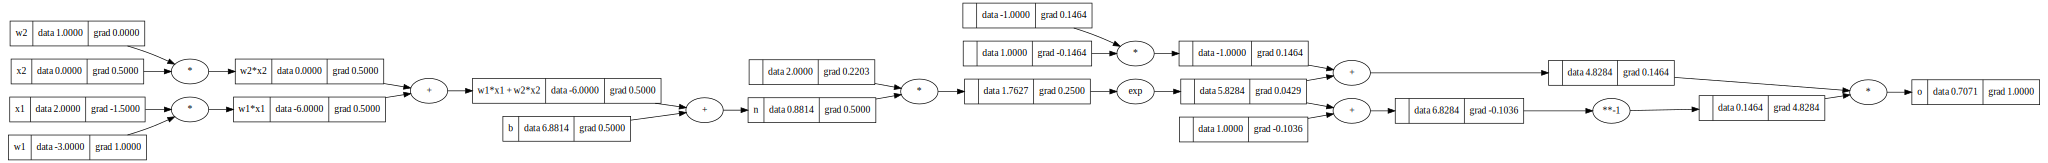

In [ ]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bais
b = Value(6.8813735870195432, label='b')

w1x1 = w1 * x1; w1x1.label = 'w1*x1'
w2x2 = w2 * x2; w2x2.label = 'w2*x2'
w1x1w2x2 = w1x1 + w2x2 ; w1x1w2x2.label = 'w1*x1 + w2*x2'
n = w1x1w2x2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---
o.label='o'
o.backward()
draw_root(o)

In [ ]:
import torch

In [ ]:
x1 = torch.tensor([2.0]).double();                  x1.requires_grad=True
x2 = torch.tensor([0.0]).double();                  x2.requires_grad=True
w1 = torch.tensor([-3.0]).double();                 w1.requires_grad=True
w2 = torch.tensor([1.0]).double();                  w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double();    b.requires_grad=True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)
o.backward()

In [ ]:
import random

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.weight = [Value(random.uniform(-1,1)) for _ in range (nin)]
    self.bais  = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.weight, x)), self.bais)
    out = act.tanh()
    return out

  def parameters(self):
    return self.weight + [self.bais]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

  def parameters(self):
    params = []

    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:

  def __init__ (self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range (len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      ps = layer.parameters()
      params.extend(ps)

    return params

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value(data = -0.8905612230716842)]

In [ ]:
n.parameters()

[Value(data = 0.20937929268434474),
 Value(data = 0.23714933115947145),
 Value(data = 0.047585895456891514),
 Value(data = 0.9498294549741884),
 Value(data = 0.20973935010593903),
 Value(data = -0.6454253445603808),
 Value(data = 0.5764485422756633),
 Value(data = 0.5942414632388138),
 Value(data = -0.9598354065394059),
 Value(data = 0.11623888154560347),
 Value(data = 0.5556131623720932),
 Value(data = -0.7259496696841066),
 Value(data = 0.6235177625707364),
 Value(data = 0.7575693829749539),
 Value(data = -0.5039193951576111),
 Value(data = 0.4926461641335309),
 Value(data = -0.3903396169599411),
 Value(data = -0.28789109445268535),
 Value(data = 0.704791843623505),
 Value(data = 0.3473368557818979),
 Value(data = 0.11218483885013364),
 Value(data = -0.695410383189174),
 Value(data = 0.8551188476975295),
 Value(data = -0.12800371370491614),
 Value(data = 0.46033911007973183),
 Value(data = -0.16627328361559335),
 Value(data = 0.6886317235194206),
 Value(data = -0.991469704809095),
 V

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred= [n(x) for x in xs]
ypred

[[Value(data = -0.8905612230716842)],
 [Value(data = -0.6007021967035115)],
 [Value(data = -0.6852174374667024)],
 [Value(data = -0.8663475586875221)]]

In [ ]:
((y - ygt)**2 for y, ygt in zip(ys, ypred))

<generator object <genexpr> at 0x7fe689095460>

In [ ]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  # loss = sum([(yout[0] - Value(ygt))**2 for ygt, yout in zip(ys, ypred)]) # Original line causing the error

  losses = [(yout[0] - Value(ygt))**2 for ygt, yout in zip(ys, ypred)]
  loss = Value(0.0)  # Initialize loss as a Value object
  for l in losses:
      loss = loss + l # Explicitly use the overloaded + operator


  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 7.316001745393608
1 5.784512128874079
2 4.019479467317774
3 5.455830976074195
4 2.034342755152014
5 1.971071967648053
6 0.6521734284955151
7 0.04994981198158039
8 0.04504430912921815
9 0.0410250510717276
10 0.0376542790702237
11 0.03477953331609861
12 0.0322959379337186
13 0.03012773996942746
14 0.02821826493537892
15 0.026523979956749627
16 0.025010752246417686
17 0.02365137113493088
18 0.022423842168662705
19 0.021310176160959954
